In [1]:
!pip install scikit-image

In [2]:
import tensorflow as tf
import numpy as np
import os

from skimage.io import imread,imshow
from skimage.transform import resize
from skimage import color
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

In [3]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
CHANNELS = 3


training_images_names = os.listdir('C:\\Users\\Janan\\OneDrive\\Desktop\\Naan MUdhalvan\\Training_Images')
training_masks_names = os.listdir('C:\\Users\\Janan\\OneDrive\\Desktop\\Naan MUdhalvan\\masks')

X = np.zeros((len(training_images_names),IMG_HEIGHT,IMG_WIDTH,CHANNELS),dtype='uint8')
y = np.zeros((len(training_masks_names),IMG_HEIGHT,IMG_WIDTH,1))

In [4]:
for i,n in enumerate(training_images_names):
    img = imread(f'C:\\Users\\Janan\\OneDrive\\Desktop\\Naan MUdhalvan\\Training_Images/{n}')
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH,CHANNELS),mode='constant',preserve_range=True)
    fn = str(n.split('.')[0]) + '.png'
    mask = imread(f'C:\\Users\\Janan\\OneDrive\\Desktop\\Naan MUdhalvan\\masks/{fn}')
    mask = resize(mask,(IMG_HEIGHT,IMG_WIDTH,1),mode='constant')

    X[i] = img
    y[i] = mask

X[0].shape

(256, 256, 3)

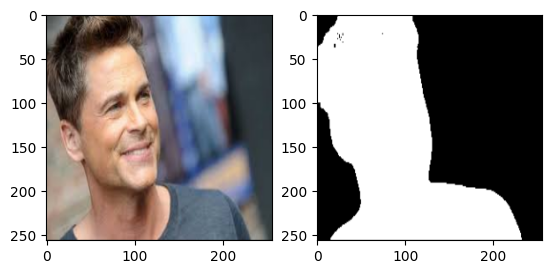

In [5]:
i = np.random.randint(0,len(X))
fig,(a1,a2)=plt.subplots(1,2)
a1.imshow(X[i])
a2.imshow(y[i].reshape(y[i].shape[:-1]),cmap='gray')

In [8]:
#building U-Net

inputs = tf.keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,CHANNELS))
s = tf.keras.layers.Lambda(lambda x:x/255)(inputs)

#contracting path
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)


c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)


c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)


c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)


c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5_1 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
c5_1 = tf.keras.layers.Dropout(0.3)(c5_1)
c5_2 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5_1)
c5_3 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',dilation_rate=2)(c5_2)
c5_4 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',dilation_rate=2)(c5_3 )
c5_5 = tf.keras.layers.concatenate([c5_1,c5_4])


#expanding path
u4 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5_5)
u4 = tf.keras.layers.concatenate([u4,c4])
u4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u4)
u4 = tf.keras.layers.Dropout(0.2)(u4)
u4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u4)


u3 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(u4)
u3 = tf.keras.layers.concatenate([u3,c3])
u3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u3)
u3 = tf.keras.layers.Dropout(0.2)(u3)
u3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u3)


u2 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(u3)
u2 = tf.keras.layers.concatenate([u2,c2])
u2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u2)
u2 = tf.keras.layers.Dropout(0.2)(u2)
u2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u2)


u1 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(u2)
u1 = tf.keras.layers.concatenate([u1,c1])
u1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u1)
u1 = tf.keras.layers.Dropout(0.2)(u1)
u1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u1)

output = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(u1)

model = tf.keras.Model(inputs=[inputs],outputs=[output])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 256, 256,  │        448 │ lambda_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 256, 256,  │          0 │ conv2d_44[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_20[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 128, 128,  │          0 │ conv2d_46[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_21[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_47[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 64, 64,    │          0 │ conv2d_48[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_22[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ conv2d_49[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 32, 32,    │          0 │ conv2d_50[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_23[0][0]

 Total params: 4,563,569 (17.41 MB)

 Trainable params: 4,563,569 (17.41 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.1, random_state=42)

In [10]:
# TRAINING MODEL

results = model.fit(X_train,y_train,batch_size=16,epochs=10)
model.save('models/human_segmentation_non-aug_100_v2.h5')

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.5863 - loss: 0.6856
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.7014 - loss: 0.6045
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.7114 - loss: 0.5721
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.7151 - loss: 0.5333
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.7292 - loss: 0.4929
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.7604 - loss: 0.4673
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.7569 - loss: 0.4790
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.7565 - loss: 0.4422
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 133s 8s/step - accuracy: 0.7885 - loss: 0.4301
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.8044 - loss: 0.3966


In [11]:
a1.plot(np.arange(0, 10), results.history['loss'], label='loss')
a2.plot(np.arange(0, 10), results.history['accuracy'], label='accuracy')


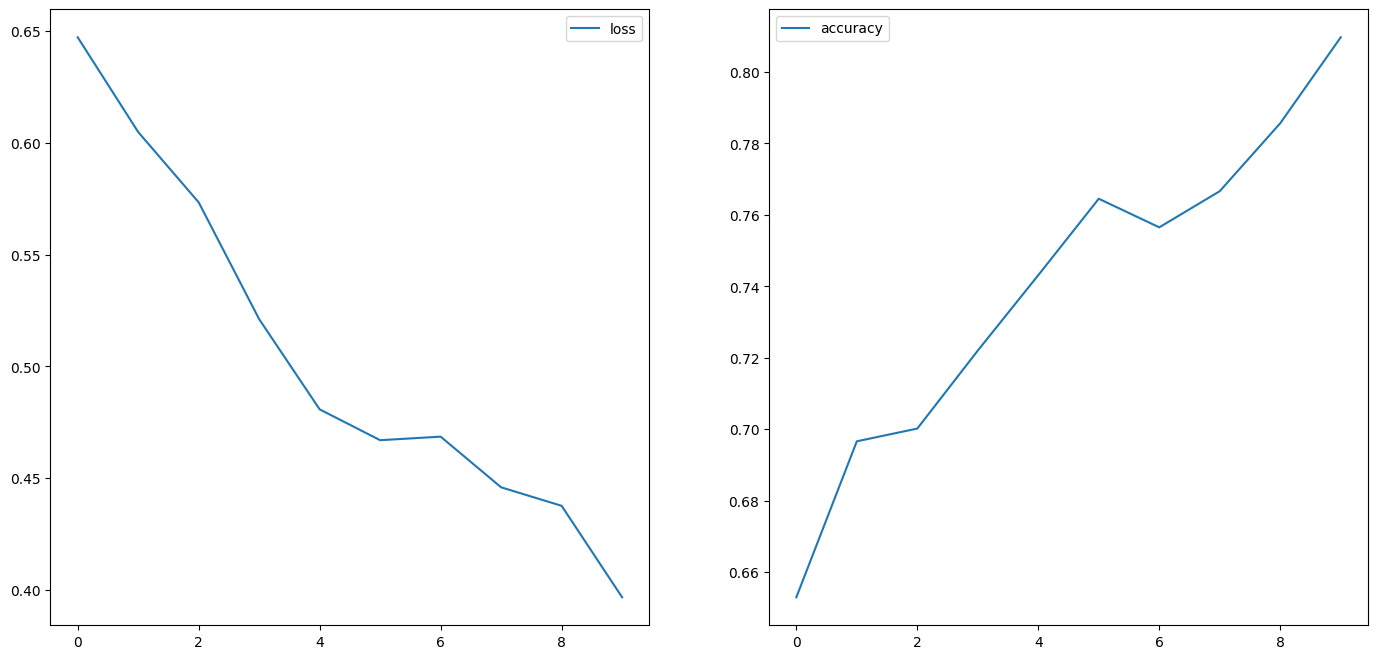

In [12]:
fig,(a1,a2) = plt.subplots(1,2,figsize=(17,8))
epochs = len(results.history['loss'])
a1.plot(np.arange(0, epochs), results.history['loss'], label='loss')
a2.plot(np.arange(0, epochs), results.history['accuracy'], label='accuracy')
a1.legend()
a2.legend()
plt.savefig('losses_and_accuracies_100_v2.png')



In [13]:
print(results.history['accuracy'],"accuracy")

[0.6529949307441711, 0.6966323852539062, 0.7001937627792358, 0.7220229506492615, 0.7431188225746155, 0.7644942402839661, 0.7564911842346191, 0.7666189074516296, 0.7856261134147644, 0.8096692562103271] accuracy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


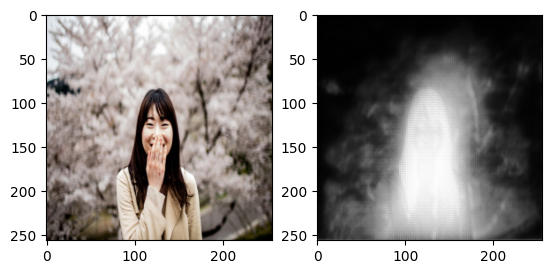

In [14]:
k=np.random.randint(0,len(X_test))
fig,(a1,a2) = plt.subplots(1,2)

a1.imshow(X_test[k])

(h,w,c) = X_test[k].shape
i = X_test[k].reshape((1,h,w,c))

pred = model.predict(i)

a2.imshow(pred.reshape(pred.shape[1:-1]),cmap='gray')